In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch

from cloudcasting.dataset import SatelliteDataModule, SatelliteDataset

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# Instantiate the torch dataset object
dataset = SatelliteDataset(
    zarr_path="path/to/satellite/data/2020_nonhrv.zarr",
    start_time="2020-06-01",
    end_time="2020-06-15",
    history_mins=60,
    forecast_mins=180,
    sample_freq_mins=15,
)

In [3]:
# Number of complete samples in the dataset
# - this includes overlapping periods, not completely distinct periods
n_samples = len(dataset)
print(n_samples)

1404


In [4]:
# Speed test
%timeit -n 3 -r 10 dataset[np.random.randint(n_samples)]

1.15 s ± 244 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)


In [5]:
# Index out a single sample
X, y = dataset[30]

In [6]:
type(X)

numpy.ndarray

In [7]:
X.shape # (channels, time, height, width)

(11, 5, 372, 614)

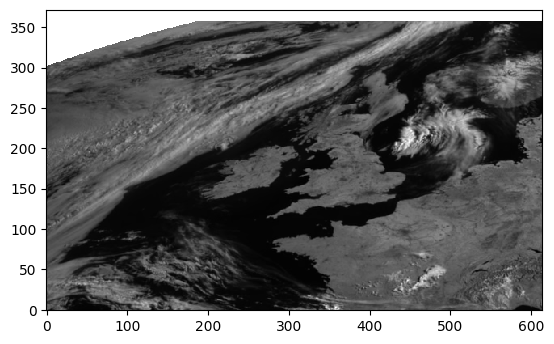

In [8]:
# Slice a single image from the input data and select a single channel
# The channel at index 8 is the VIS008 visual channel
single_image = X[8, 0]

# Need to reverse the x-axis since the data is reversed in this dimension on disk
single_image = single_image[:, ::-1]

plt.imshow(single_image, cmap='gist_grey', interpolation='nearest', origin="lower")
plt.show()

In [9]:
# Instantiate a lightning datamodule
datamodule = SatelliteDataModule(
    zarr_path="path/to/satellite/data/2020_nonhrv.zarr",
    history_mins=60,
    forecast_mins=180,
    sample_freq_mins=15,
    batch_size=16,
    num_workers=8,
    prefetch_factor=2,
    train_period=["2020-06-01", "2020-06-19"],
    val_period=["2020-06-20", "2020-06-25"],
    test_period=["2020-06-26", "2020-06-30"],
)

In [10]:
# Instantiate the train dataloader
train_dataloader = datamodule.train_dataloader()

In [11]:
# Speed test of the dataloader
t_last = time.time()
for i, (_X, _y) in zip(range(20), train_dataloader, strict=False):
    t_now = time.time()
    print(f"Batch {i} took : {t_now-t_last:.3f} seconds")
    t_last = t_now

Batch 0 took : 42.034 seconds
Batch 1 took : 1.002 seconds
Batch 2 took : 0.498 seconds
Batch 3 took : 0.337 seconds
Batch 4 took : 0.245 seconds
Batch 5 took : 0.259 seconds
Batch 6 took : 0.240 seconds
Batch 7 took : 0.857 seconds
Batch 8 took : 19.598 seconds
Batch 9 took : 4.098 seconds
Batch 10 took : 0.413 seconds
Batch 11 took : 0.358 seconds
Batch 12 took : 0.360 seconds
Batch 13 took : 0.351 seconds
Batch 14 took : 1.087 seconds
Batch 15 took : 1.888 seconds
Batch 16 took : 31.063 seconds
Batch 17 took : 3.635 seconds
Batch 18 took : 0.230 seconds
Batch 19 took : 0.239 seconds


In [12]:
# Lets grab the last batch the dataloader yielded
X = _X
y = _y

In [13]:
type(X)

torch.Tensor

In [14]:
X.shape # (batch size, channels, time, height, width)

torch.Size([16, 11, 5, 372, 614])

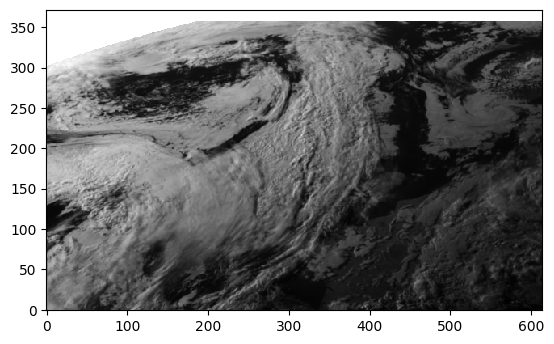

In [15]:
# Slice the VIS008 channel from a single image from the input data
single_image = X[0, 8, 0].numpy()

# Need to reverse the x-axis since the data is reversed in this dimension on disk
single_image = single_image[:, ::-1]

plt.imshow(single_image, cmap='gist_grey', interpolation='nearest', origin="lower")
plt.show()

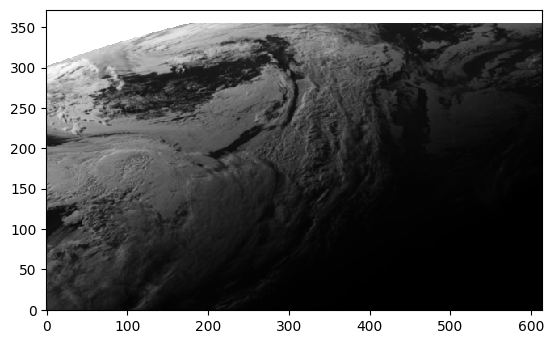

In [16]:
# Slice the accompanying target for the above
single_image = y[0, 8, 0].numpy()

single_image = single_image[:, ::-1]

plt.imshow(single_image, cmap='gist_grey', interpolation='nearest', origin="lower")
plt.show()

Looks like this example was towards dusk. Channel 8 which we plotted above is one of the visual channels, and we can't see what is happening in the bottom right. But we could see what is happening if we use one of the IR channels

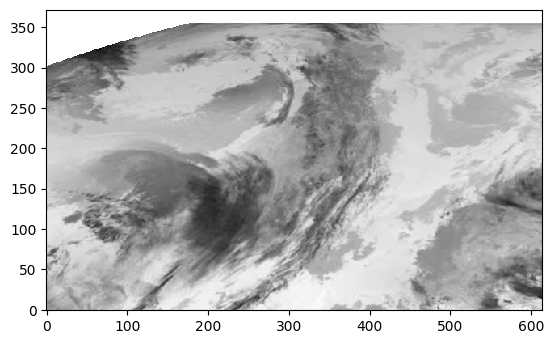

In [17]:
# Select one of the infrared channels for the image above
# the channel at index 2 is the IR_087 channel
single_image = y[0, 2, 0].numpy()
single_image = single_image[:, ::-1]

plt.imshow(single_image, cmap='gist_grey', interpolation='nearest', origin="lower")
plt.show()